In [ ]:
## Loading file paths and importing
import numpy as np
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import io, segmentation, color
from PIL import Image


seg_path = r'/content/drive/MyDrive/biotech/Retina_Lab/C3_00010000_seg.npy'
image_path = r'/content/drive/MyDrive/biotech/Retina_Lab/C3_00010000.png'
model_weight_path = r'/content/drive/MyDrive/biotech/Retina_Lab/Image_data/best_model.h5'



## Load the image and seg files
- the seg file is a dictionary!

In [ ]:
## Load the files
img = io.imread(image_path)

# ─── load the Cellpose .npy (it's saved as a dict) ───
raw = np.load(seg_path, allow_pickle=True)
data = raw.item()            # now data is a dict
masks = data['masks']        # int32 label array, shape == img.shape[:2]

# Print shapes for debugging
print(f"  Image shape: {img.shape}")
print(f"  Masks shape: {masks.shape}")

# Check if the masks shape matches the image shape
if masks.shape[:2] != img.shape[:2]:
    print(f"  Warning: Mask shape {masks.shape[:2]} doesn't match image shape {img.shape[:2]}")
else:
  print('All seems fine :)')

  Image shape: (1024, 1024, 3)
  Masks shape: (1024, 1024)
All seems fine :)


## Load the model

In [ ]:
model = load_model(model_weight_path)
img_width, img_height = 224, 224
test_datagen = ImageDataGenerator(rescale=1./255)

print('Loaded successfully')

Loaded successfully


## Extract Cell regions
- store the extracted cell regions in a dictionary, segment_data

In [ ]:
segment_data = {}

for lab in np.unique(masks):
    if lab == 0:  # Skip background
        continue

    # boolean mask for this cell
    m = masks == lab
    ys, xs = np.where(m)
    if len(ys) == 0 or len(xs) == 0:
        continue

    y0, x0 = ys.min(), xs.min()
    y1, x1 = ys.max() + 1, xs.max() + 1

    # crop image & mask
    patch = img[y0:y1, x0:x1].copy()
    m_crop = m[y0:y1, x0:x1]

    # zero-out background based on image dimensions
    if patch.ndim == 3:
        # Handle multi-channel images (RGB or RGBA)
        for c in range(patch.shape[2]):
            channel = patch[:, :, c]
            channel[~m_crop] = 0
            patch[:, :, c] = channel
    else:
        # Handle grayscale images
        patch = patch * m_crop

    # Store the segment and initialize prediction space
    segment_data[lab] = {
        "image": patch,
        "prediction": None
    }

print('All the cells are done whohoo :))')
print('Segments stored in memory.')
print('Total number of segments:', len(segment_data))


All the cells are done whohoo :))
Segments stored in memory.
Total number of segments: 388


## Function to preprocess images before feeding the model
- resize
- make it RGB

In [ ]:
def pre_proccess_image(img, target_size =(224,224)):
    # Convert to RGB if not already (VGG16 expects RGB)
    if img.mode != 'RGB':
        img = img.convert('RGB')

    # Resize image
    img = img.resize(target_size, Image.LANCZOS)

    return img

## Extract the segments and store locally

In [ ]:
#segment_data

## preproccees each cell image before feeding to the model
- store results in processed_segment_data
- CAN MERGE THESE LOOPS INTO A SINGLE LOOP, can store the og segment and the processed in the same dictioanry

In [ ]:
import numpy as np
# Preprocess each segment image
processed_segment_data = {}
for lab, data in segment_data.items():
    image = data['image']
    # Convert the image to PIL Image format
    image_pil = Image.fromarray(image.astype(np.uint8))

    # Preprocess the image
    processed_image = pre_proccess_image(image_pil)

    processed_segment_data[lab] = {
        "image": np.array(processed_image),  # Convert back to NumPy array
        "prediction": None
    }

print('Segments processed and ready to feed into the model.')
#processed_segment_data


Segments processed and ready to feed into the model.


## MAke the predictions
- add another dimension to each key in the processed_segment_data dictionary that contains the prediction confidence
- AGAIN, CAN MAKE MORE EFFICIENT BY COMBINING THE CODE. this a lil tricky but.

In [ ]:
# Iterate through the processed segment data and make predictions
for lab, data in processed_segment_data.items():
    # Prepare the image for prediction
    image = data['image']
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    image = image / 255.0  # Normalize pixel values

    # Make the prediction
    prediction = model.predict(image)
    processed_segment_data[lab]['prediction'] = prediction

print("Predictions completed for all segments.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━

In [ ]:
# sanity check
print(len(processed_segment_data))
print(processed_segment_data[1])


388
{'image': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 'prediction': array([[0.14962947, 0.8503706 ]], dtype=float32)}


## Overlay predictions on Cell regions

In [ ]:
import cv2

# Overlay predictions on the original image
overlay_image = img.copy()

for lab, data in processed_segment_data.items():
    prediction_pr = data['prediction'][0][0]  # Extract the prediction value for pr
    prediction_other = data['prediction'][0][1]  # Extract the prediction value for other

    # Get the original segment mask
    m = masks == lab

    # Define colors for the outline
    if prediction_pr < prediction_other:
        color = (0, 255, 0)  # Green for class 'prs'
    else:
        color = (0, 0, 255)  # Blue for class 'others'

    # Convert the mask to an 8-bit image required by findContours
    mask_8bit = m.astype(np.uint8) * 255

    # Find contours in the mask
    contours, _ = cv2.findContours(mask_8bit, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours on the overlay image
    cv2.drawContours(overlay_image, contours, -1, color, 2)

## Save and display the image

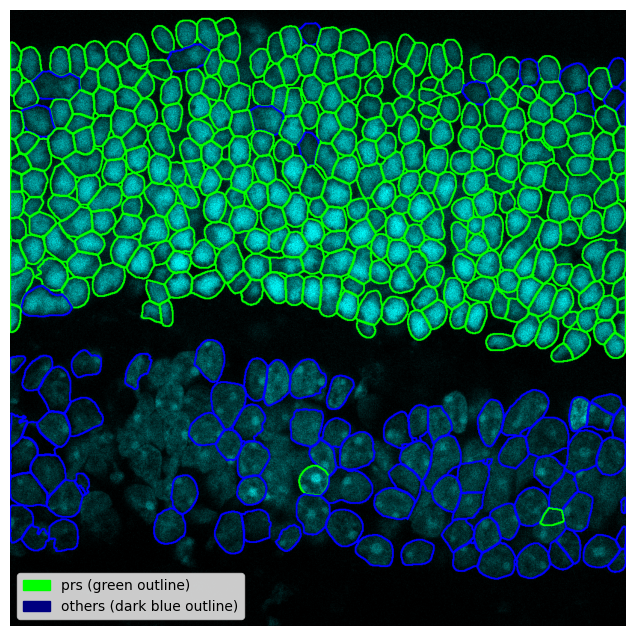

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Save the image
from PIL import Image
im = Image.fromarray(overlay_image)
im.save('/content/drive/MyDrive/biotech/Retina_Lab/classified_contour_overlay_ret3.png')

# Display the image in the notebook
plt.figure(figsize=(10, 8))
plt.imshow(overlay_image)
plt.axis('off')  # Hide axes

# Add legend
green_patch = mpatches.Patch(color='#00FF00', label='prs (green outline)')
blue_patch = mpatches.Patch(color='#000080', label='others (dark blue outline)')
plt.legend(handles=[green_patch, blue_patch], loc='lower left', frameon=True)

plt.show()